# Enabling a RAG Model
Adapted from [Sergio Paniego](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms).

If you want to use the [byaldi](https://github.com/AnswerDotAI/byaldi) package, you have to install [Poppler](https://poppler.freedesktop.org/) first.

### First, download all pdfs from zenodo


In [2]:
import sys
import os

# Add parent directory to be able to import modules
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [11]:
import pandas as pd
from natsort import natsorted
from caching import load_full_hf_cache, get_zenodo_pdfs
from pdf_utilities import download_all_pdfs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from PyPDF2 import PdfReader

In [9]:
# Function to download all PDFs from the Training Material
download_all_pdfs(repo_name = "ScaDS-AI/SlideInsight_Cache", save_dir="zenodo_pdfs")

All PDFs downloaded!


### Second, create instance of the Byaldi RAG Model

In [6]:
from byaldi import RAGMultiModalModel

# if CUDA is not available, change to device = "cpu"
docs_retrieval_model = RAGMultiModalModel.from_pretrained(pretrained_model_name_or_path = "vidore/colpali-v1.2", device = "cpu")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
# Function to index the pdfs from scratch
docs_retrieval_model.index(input_path="zenodo_pdfs/", index_name="pdf_index", store_collection_with_index=True, overwrite=True)

NameError: name 'docs_retrieval_model' is not defined

In [3]:
docs_retrieval_model = RAGMultiModalModel.from_index("pdf_index", device='cpu')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 2534 images from 6 JSON files.


/home/lea/.local/lib/python3.10/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))


In [38]:
text_query = "What are the most popular methods for Segmentation in biological Images?"

k_results = 20
results = docs_retrieval_model.search(text_query, k=k_results)

### Cluster results based on their similarity in 'score' entry.
Results are clustered into 2 groups according their scores for the query. Then, the best 2 results per cluster are saved for further processing.
This ensures a wider range of diverse answers, that still fit well to the query. 

In [39]:
# Extract the scores from your results
scores = [item['score'] for item in results]

# Convert to 2D array for KMeans
X = np.array(scores).reshape(-1, 1)

# Cluster into 2 groups
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

# Group results by cluster
cluster_0 = []
cluster_1 = []

for i, label in enumerate(labels):
    if label == 0:
        cluster_0.append(results[i])
    else:
        cluster_1.append(results[i])

# Sort each cluster by score (optional)
cluster_0 = sorted(cluster_0, key=lambda x: x['score'])
cluster_1 = sorted(cluster_1, key=lambda x: x['score'])

# Print clusters
print("\n Cluster 0:")
for item in cluster_0:
    print(f"doc_id: {item['doc_id']}, score: {item['score']}")

print("\n Cluster 1:")
for item in cluster_1:
    print(f"doc_id: {item['doc_id']}, score: {item['score']}")

# Take first 2 from each cluster
selected_results = cluster_0[:2] + cluster_1[:2]


 Cluster 0:
doc_id: 18, score: 15.3125
doc_id: 44, score: 15.3125
doc_id: 44, score: 15.3125
doc_id: 45, score: 15.3125
doc_id: 44, score: 15.3125
doc_id: 44, score: 15.4375
doc_id: 43, score: 15.75
doc_id: 61, score: 16.375

 Cluster 1:
doc_id: 45, score: 14.8125
doc_id: 43, score: 14.8125
doc_id: 44, score: 14.875
doc_id: 45, score: 14.9375
doc_id: 10, score: 15.0
doc_id: 43, score: 15.0
doc_id: 44, score: 15.0
doc_id: 39, score: 15.0625
doc_id: 53, score: 15.0625
doc_id: 43, score: 15.125
doc_id: 42, score: 15.125
doc_id: 43, score: 15.125


In [66]:
from PIL import Image
import base64
from io import BytesIO

reconstructed_images = []

for result in selected_results:
    base64_img = result["base64"]  
    image_data = base64.b64decode(base64_img)
    image = Image.open(BytesIO(image_data))
    reconstructed_images.append(image)

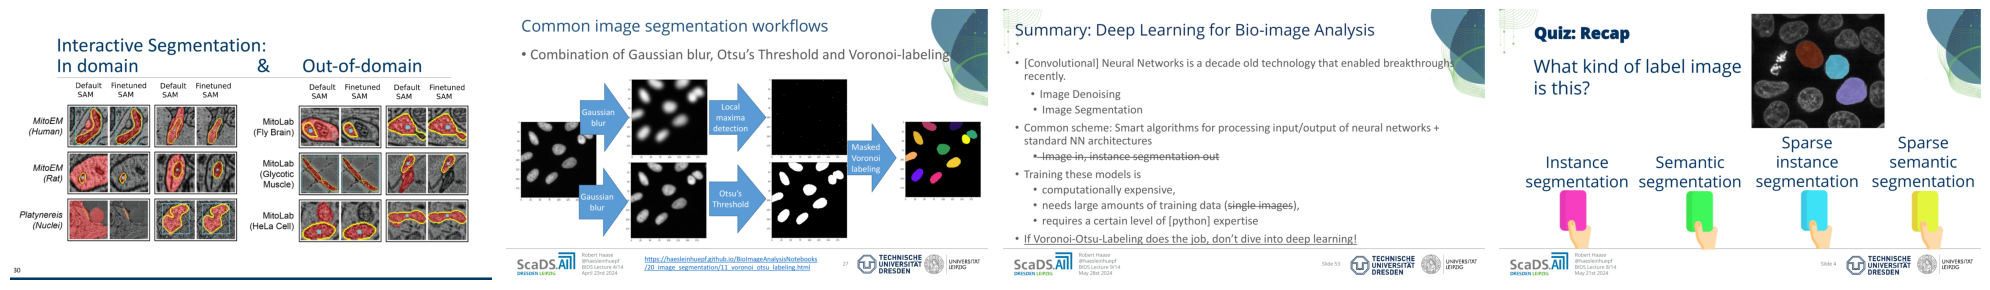

In [67]:
# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(reconstructed_images), figsize=(20, 8))

for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


## Now connect to the VLM Model, th generate some meaningful repsonses

In [7]:
from openai import OpenAI

# access the VLM via the SCADS API
my_api_key = os.getenv('SCADS_KEY')

In [8]:
client = OpenAI(base_url="https://llm.scads.ai/v1",api_key=my_api_key)

print("""Available models:""")
for model in client.models.list().data:
    print(model.id)

Available models:
deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct
openGPT-X/Teuken-7B-instruct-research-v0.4
tts-1-hd
meta-llama/Llama-4-Scout-17B-16E-Instruct
meta-llama/Llama-3.3-70B-Instruct
en-de-translator
Alibaba-NLP/gte-Qwen2-1.5B-instruct
deepseek-ai/DeepSeek-R1
Qwen/Qwen2-VL-7B-Instruct


In [9]:
for model in client.models.list().data:
    model_name = model.id
    if "Llama-4-Scout" in model_name:
        break

### Convert the image content to a VLM message

In [68]:
def encode_pil_image(pil_img, max_size=(512, 512)):
    # Downsize the image (keeps aspect ratio)
    pil_img = pil_img.copy()
    pil_img.thumbnail(max_size)

    buffered = BytesIO()
    pil_img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


# Convert each image to base64 data URL format
image_contents = [
    {
        "type": "image_url",
        "image_url": {
            "url": encode_pil_image(img)
        }
    }
    for img in reconstructed_images
]

# Add the text query
image_contents.append({
    "type": "text",
    "text": f"{text_query}"
})

In [69]:
# Send the request to the VLM
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {
            "role": "system",
            "content": "Try to anwser the following question using information from the given images, combined with the knowledge you have. Also try to answer in a short, but precise manner. Don't anwser in more than 10 sentences or bullet points.",
            "role": "user",
            "content": image_contents
        }
    ],
    max_tokens=500
)

### Get the response

In [70]:
summary = response.choices[0].message.content
print(summary)

The most popular methods for segmentation in biological images are:

1. **Convolutional Neural Networks (CNNs)**: A decade-old technology that has enabled breakthroughs in image segmentation tasks.
2. **Combination of Gaussian blur, Otsu's Threshold, and Voronoi-labeling**: A common workflow for image segmentation, which involves:
	* **Gaussian blur**: Reducing noise in images.
	* **Otsu's Threshold**: Automatically determining the optimal threshold for image segmentation.
	* **Voronoi-labeling**: Labeling objects based on their proximity to each other.

These methods are widely used in bio-image analysis for tasks such as:

* Image denoising
* Image segmentation

Additionally, **deep learning** has also been applied to image segmentation tasks, including:

* **Instance segmentation**: Identifying individual objects within an image.
* **Semantic segmentation**: Assigning a label to each pixel in an image.

These methods are used to analyze biological images, such as those obtained thro

### Compare answer to a requets without images

In [71]:
# Send the request to the VLM
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {
            "role": "system",
            "content": "Try to answer in a short, but precise manner. Don't anwser in more than 10 sentences or bullet points.",
            "role": "user",
            "content": text_query
        }
    ],
    max_tokens=500
)

In [72]:
summary = response.choices[0].message.content
print(summary)

Segmentation in biological images is a crucial step for further analysis, such as cell tracking, morphometry, and understanding tissue structure. The goal is to partition an image into meaningful regions, typically to isolate objects of interest (e.g., cells, nuclei, organelles) from the background or from each other. Over the years, several methods have been developed and popularized in the field of biological image analysis. Here are some of the most commonly used approaches:

### 1. **Thresholding-based Methods**

Thresholding is one of the simplest and most widely used techniques for image segmentation. It works by setting a threshold value for the pixel intensity and classifying pixels as either part of the object or the background based on this threshold. There are several types of thresholding, including:

- **Otsu's Thresholding**: Automatically determines the optimal threshold by minimizing the variance within the classes (object and background) or maximizing the variance betw